In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils, callbacks
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics



In [ ]:
from scipy.stats import wilcoxon, friedmanchisquare
import seaborn as sns

In [ ]:
train_folder = 'D:/Sougata/Jochen_Triesch_ASL/train'
all_data = []
for folder in os.listdir(train_folder):

    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

      label                                            path
0         a     D:/Sougata/Jochen_Triesch_ASL/train\a\0.jpg
1         a     D:/Sougata/Jochen_Triesch_ASL/train\a\1.jpg
2         a     D:/Sougata/Jochen_Triesch_ASL/train\a\2.jpg
3         a     D:/Sougata/Jochen_Triesch_ASL/train\a\3.jpg
4         a     D:/Sougata/Jochen_Triesch_ASL/train\a\4.jpg
...     ...                                             ...
29995     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2995.jpg
29996     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2996.jpg
29997     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2997.jpg
29998     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2998.jpg
29999     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2999.jpg

[30000 rows x 2 columns]


In [ ]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [ ]:
img_width, img_height = 64, 64
batch_size = 64
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=True
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)


Found 21000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.
Found 3000 validated image filenames belonging to 10 classes.


In [ ]:
# New Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

model5 = Sequential()

model5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model5.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model5.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

class InceptionModule(Layer):
    def __init__(self, filters=64, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):

        self.conv1x1 = Conv2D(filters=self.filters, kernel_size=(1, 1), activation='relu', padding='same')
        self.conv3x3 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5x5 = Conv2D(filters=self.filters, kernel_size=(5, 5), activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')
        super(InceptionModule, self).build(input_shape)

    def call(self, x):

        tower_1 = self.conv1x1(x)

        tower_2 = self.conv1x1(x)
        tower_2 = self.conv3x3(tower_2)

        tower_3 = self.conv1x1(x)
        tower_3 = self.conv5x5(tower_3)

        tower_4 = self.pool(x)
        tower_4 = self.conv1x1(tower_4)


        output = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
        return output


model5.add(InceptionModule(filters=64))

model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())

model5.add(Reshape((1, -1)))

model5.add(LSTM(units=128, return_sequences=True))

# Define CASDPA mechanism (Context-Augmented Scaled Dot-Product Attention)
class CASDPA(Layer):
    def __init__(self, use_scale=True):
        super(CASDPA, self).__init__()
        self.use_scale = use_scale

    def build(self, input_shape):

        self.query_matrix = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                            initializer='glorot_uniform',
                                            trainable=True,
                                            name='query_matrix')


        self.global_avg_pool = GlobalAveragePooling1D()

    def call(self, inputs):

        context_vector = self.global_avg_pool(inputs)
        context_vector = tf.expand_dims(context_vector, axis=1)


        query = tf.matmul(inputs, self.query_matrix)
        value = inputs


        score = tf.matmul(query, value, transpose_b=True)


        if self.use_scale:
            d_k = tf.cast(tf.shape(value)[-1], tf.float32)
            score = score / tf.math.sqrt(d_k)


        attention_weights = tf.nn.softmax(score, axis=-1)


        context_augmented_attention = tf.matmul(attention_weights, value) + context_vector

        return context_augmented_attention


model5.add(CASDPA(use_scale=True))

model5.add(Flatten())

model5.add(Dense(units=no_of_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_4 (Batc (None, 62, 62, 32)        128       
 hNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling (None, 31, 31, 32)        0         
 2D)                                                            
                                                                 
 spectral_conv2d_3 (Spectral (None, 31, 31, 64)        18496     
 Conv2D)                                                        
                                                                 
 polynomial_conv2d_3 (Polyno (None, 31, 31, 64)        36928     
 mialConv2D)                                             

In [ ]:
# New Model with CNN + spectral CNN + polynomial CNN + inception Module + CASDPA mechanism
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)


model5 = Sequential()

# Spatial Feature Extraction (CNN)
model5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model5.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model5.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

class InceptionModule(Layer):
    def __init__(self, filters=64, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1x1 = Conv2D(filters=self.filters, kernel_size=(1, 1), activation='relu', padding='same')
        self.conv3x3 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5x5 = Conv2D(filters=self.filters, kernel_size=(5, 5), activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')
        super(InceptionModule, self).build(input_shape)

    def call(self, x):
        tower_1 = self.conv1x1(x)

        tower_2 = self.conv1x1(x)
        tower_2 = self.conv3x3(tower_2)

        tower_3 = self.conv1x1(x)
        tower_3 = self.conv5x5(tower_3)

        tower_4 = self.pool(x)
        tower_4 = self.conv1x1(tower_4)

        output = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
        return output

model5.add(InceptionModule(filters=64))

model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())

model5.add(Reshape((1, -1)))

model5.add(LSTM(units=128, return_sequences=True))

class CASDPA(Layer):
    def __init__(self, use_scale=True):
        super(CASDPA, self).__init__()
        self.use_scale = use_scale

    def build(self, input_shape):
        # Query matrix as a trainable weight
        self.query_matrix = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                            initializer='glorot_uniform',
                                            trainable=True,
                                            name='query_matrix')

        self.global_avg_pool = GlobalAveragePooling1D()

    def call(self, inputs):
        context_vector = self.global_avg_pool(inputs)
        context_vector = tf.expand_dims(context_vector, axis=1)  # Expand dimensions for proper broadcasting

        query = tf.matmul(inputs, self.query_matrix)
        value = inputs

        score = tf.matmul(query, value, transpose_b=True)

        if self.use_scale:
            d_k = tf.cast(tf.shape(value)[-1], tf.float32)
            score = score / tf.math.sqrt(d_k)

        attention_weights = tf.nn.softmax(score, axis=-1)

        context_augmented_attention = tf.matmul(attention_weights, value) + context_vector

        return context_augmented_attention

model5.add(CASDPA(use_scale=True))

model5.add(Flatten())

model5.add(Dense(units=no_of_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                                 patience=5, restore_best_weights=True)

classes = 10
epochs = 12
learning_rate = 0.0001

history5 = model5.fit(train_generator,
                      epochs=epochs,
                      verbose=1,
                      validation_data=validation_generator,
                      shuffle=True, callbacks=[earlystopping])

Epoch 1/12
938/938 [==============================] - 190s 2s/step - loss: 2.7743 - accuracy: 0.3596 - val_loss: 3.0359 - val_accuracy: 0.3056
Epoch 2/12
938/938 [==============================] - 230s 234ms/step - loss: 1.3847 - accuracy: 0.6378 - val_loss: 1.7510 - val_accuracy: 0.5833
Epoch 3/12
938/938 [==============================] - 226s 231ms/step - loss: 0.8615 - accuracy: 0.7684 - val_loss: 1.1231 - val_accuracy: 0.7069
Epoch 4/12
938/938 [==============================] - 229s 234ms/step - loss: 0.5766 - accuracy: 0.8373 - val_loss: 0.3708 - val_accuracy: 0.8653
Epoch 5/12
938/938 [==============================] - 201s 205ms/step - loss: 0.4080 - accuracy: 0.8833 - val_loss: 0.2296 - val_accuracy: 0.9208
Epoch 6/12
938/938 [==============================] - 222s 227ms/step - loss: 0.3324 - accuracy: 0.9121 - val_loss: 0.3161 - val_accuracy: 0.9111
Epoch 7/12
938/938 [==============================] - 224s 229ms/step - loss: 0.2801 - accuracy: 0.9293 - val_loss: 0.1057 - va

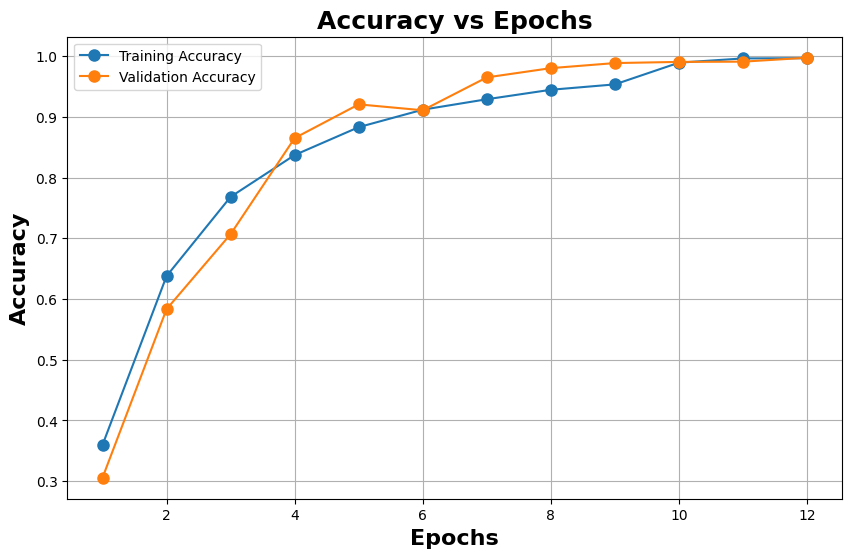

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], '-o', label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], '-o', label='Validation Accuracy')
plt.title('Accuracy vs Epochs', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

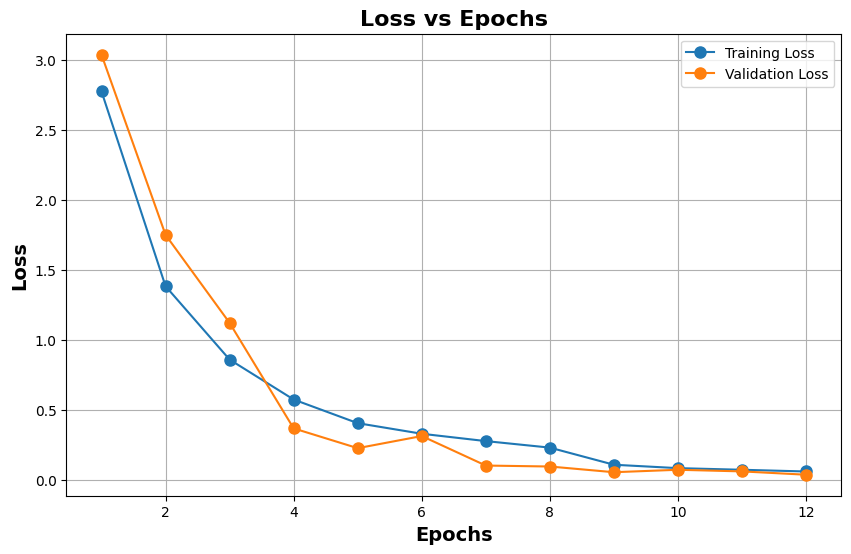

In [ ]:
# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], '-o', label='Training Loss')
plt.plot(history5.history['val_loss'], '-o', label='Validation Loss')
plt.title('Loss vs Epochs', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# New Model with CNN + spectral CNN + polynomial CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define the model
model3 = Sequential()

# Spatial Feature Extraction (CNN)
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model3.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Add custom SpectralConv2D layer
model3.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Add custom PolynomialConv2D layer
model3.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model3.add(Flatten())  # Flatten the output of the attention layer

# Classification Layer
model3.add(Dense(units=no_of_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN (None, 62, 62, 32)        128       
 ormalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2D (None, 31, 31, 32)        0         
 )                                                              
                                                                 
 spectral_conv2d (SpectralCo (None, 31, 31, 64)        18496     
 nv2D)                                                          
                                                                 
 polynomial_conv2d (Polynomi (None, 31, 31, 64)        36928     
 alConv2D)                                                 

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

classes = 10
epochs = 12
learning_rate = 0.0001

history3 = model3.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])



Epoch 1/12
938/938 [==============================] - 207s 224ms/step - loss: 2.1875 - accuracy: 0.3485 - val_loss: 1.6270 - val_accuracy: 0.3581
Epoch 2/12
938/938 [==============================] - 234s 230ms/step - loss: 1.2789 - accuracy: 0.5977 - val_loss: 1.1949 - val_accuracy: 0.6136
Epoch 3/12
938/938 [==============================] - 198s 215ms/step - loss: 0.8615 - accuracy: 0.7054 - val_loss: 0.9868 - val_accuracy: 0.7070
Epoch 4/12
938/938 [==============================] - 243s 236ms/step - loss: 0.5192 - accuracy: 0.7731 - val_loss: 0.8467 - val_accuracy: 0.8246
Epoch 5/12
938/938 [==============================] - 222s 221ms/step - loss: 0.4553 - accuracy: 0.8120 - val_loss: 0.6322 - val_accuracy: 0.8741
Epoch 6/12
938/938 [==============================] - 249s 238ms/step - loss: 0.4028 - accuracy: 0.8407 - val_loss: 0.6193 - val_accuracy: 0.8892
Epoch 7/12
938/938 [==============================] - 214s 209ms/step - loss: 0.3489 - accuracy: 0.8612 - val_loss: 0.4559 -

In [ ]:
# New Model with CNN + spectral CNN + polynomial CNN + inception Module
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define custom PolynomialConv2D layer
class PolynomialConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(PolynomialConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(PolynomialConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define the model
model4 = Sequential()

# Spatial Feature Extraction (CNN)
model4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model4.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model4.add(MaxPooling2D(pool_size=(2, 2)))

# Add custom SpectralConv2D layer
model4.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Add custom PolynomialConv2D layer
model4.add(PolynomialConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Define an Inception module as a custom Keras layer
class InceptionModule(Layer):
    def __init__(self, filters=64, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        # Define convolutional layers within the Inception module
        self.conv1x1 = Conv2D(filters=self.filters, kernel_size=(1, 1), activation='relu', padding='same')
        self.conv3x3 = Conv2D(filters=self.filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5x5 = Conv2D(filters=self.filters, kernel_size=(5, 5), activation='relu', padding='same')
        self.pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')
        super(InceptionModule, self).build(input_shape)

    def call(self, x):
        # Define the different towers of the Inception module
        tower_1 = self.conv1x1(x)

        tower_2 = self.conv1x1(x)
        tower_2 = self.conv3x3(tower_2)

        tower_3 = self.conv1x1(x)
        tower_3 = self.conv5x5(tower_3)

        tower_4 = self.pool(x)
        tower_4 = self.conv1x1(tower_4)

        # Concatenate the outputs of the towers to form the final output
        output = Concatenate(axis=-1)([tower_1, tower_2, tower_3, tower_4])
        return output

# Add the Inception module
model4.add(InceptionModule(filters=64))

model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())  # Flatten the output of the attention layer

# Classification Layer
model4.add(Dense(units=no_of_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model4.summary())



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_5 (Batc (None, 62, 62, 32)        128       
 hNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling (None, 31, 31, 32)        0         
 2D)                                                            
                                                                 
 spectral_conv2d_4 (Spectral (None, 31, 31, 64)        18496     
 Conv2D)                                                        
                                                                 
 polynomial_conv2d_3 (Polyno (None, 31, 31, 64)        36928     
 mialConv2D)                                             

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

classes = 10
epochs = 12
learning_rate = 0.0001

history4 = model4.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])



Epoch 1/12
938/938 [==============================] - 198s 228ms/step - loss: 2.1690 - accuracy: 0.3582 - val_loss: 1.3350 - val_accuracy: 0.2981
Epoch 2/12
938/938 [==============================] - 212s 234ms/step - loss: 1.1422 - accuracy: 0.6387 - val_loss: 1.1147 - val_accuracy: 0.6627
Epoch 3/12
938/938 [==============================] - 243s 217ms/step - loss: 0.7515 - accuracy: 0.7576 - val_loss: 0.4543 - val_accuracy: 0.8404
Epoch 4/12
938/938 [==============================] - 230s 221ms/step - loss: 0.5462 - accuracy: 0.8220 - val_loss: 0.4182 - val_accuracy: 0.8946
Epoch 5/12
938/938 [==============================] - 204s 206ms/step - loss: 0.4238 - accuracy: 0.8587 - val_loss: 0.1867 - val_accuracy: 0.9420
Epoch 6/12
938/938 [==============================] - 240s 236ms/step - loss: 0.3461 - accuracy: 0.8866 - val_loss: 0.2237 - val_accuracy: 0.9668
Epoch 7/12
938/938 [==============================] - 234s 225ms/step - loss: 0.2867 - accuracy: 0.9049 - val_loss: 0.2401 -

In [2]:
# New Model with CNN + spectral CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, Flatten, Reshape, Softmax, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Layer


# Define custom SpectralConv2D layer
class SpectralConv2D(Layer):
    def __init__(self, filters=64, kernel_size=(3, 3), activation='relu', **kwargs):
        super(SpectralConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.conv = Conv2D(filters=self.filters, kernel_size=self.kernel_size, activation=self.activation, padding='same')
        super(SpectralConv2D, self).build(input_shape)

    def call(self, inputs):
        return self.conv(inputs)

# Define the model
model2 = Sequential()

# Spatial Feature Extraction (CNN)
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model2.add(BatchNormalization())  # Adding Batch Normalization for improved stability and performance
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Add custom SpectralConv2D layer
model2.add(SpectralConv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model2.add(Flatten())  # Flatten the output of the attention layer

# Classification Layer
model2.add(Dense(units=no_of_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
print(model2.summary())


earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                        patience=5, restore_best_weights = True)

classes = 26
epochs = 12
learning_rate = 0.0001

history2 = model2.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_2 (Batc (None, 62, 62, 32)        128       
 hNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling (None, 31, 31, 32)        0         
 2D)                                                            
                                                                 
 spectral_conv2d_1 (Spectral (None, 31, 31, 64)        18496     
 Conv2D)                                                        
                                                                 
 flatten_3 (Flatten)         (None, 61504)             0         
                                                         

## Apply Wilcoxon Signed-Rank Test

In [ ]:
from scipy.stats import wilcoxon
import numpy as np

# Assuming 'holdout_generator' contains the test data
y_true = holdout_generator.classes  # True labels

# Generate predictions from model1 (assuming model1 has been trained similarly)
y_pred_probs_model1 = model4.predict(holdout_generator)
y_pred_model1 = np.argmax(y_pred_probs_model1, axis=1)  # Predicted labels for model1

# Generate predictions from model5
y_pred_probs_model5 = model5.predict(holdout_generator)
y_pred_model5 = np.argmax(y_pred_probs_model5, axis=1)  # Predicted labels for model5

# Wilcoxon signed-rank test between model1 and model5 predictions
statistic, p_value = wilcoxon(y_pred_model1, y_pred_model5)

# Calculate Z-statistic (since Wilcoxon produces W-statistic)
z_statistic = (statistic - (len(y_pred_model1) * (len(y_pred_model1) + 1)) / 4) / np.sqrt((len(y_pred_model1) * (len(y_pred_model1) + 1) * (2 * len(y_pred_model1) + 1)) / 24)

# Calculate Effect Size (r), where r = Z / sqrt(n)
effect_size = z_statistic / np.sqrt(len(y_pred_model1))

# Print results
print(f"Wilcoxon p-value: {p_value:.3f}")
print(f"Z-Statistic: {z_statistic:.2f}")
print(f"Effect Size: {effect_size:.2f}")

Wilcoxon p-value: 0.012
Z-Statistic: -2.48
Effect Size: 0.45


## Apply Friedman Test

In [ ]:
from scipy.stats import friedmanchisquare, rankdata
import numpy as np

y_true = holdout_generator.classes

y_pred_probs_model3 = model2.predict(holdout_generator)
y_pred_model3 = np.argmax(y_pred_probs_model3, axis=1)

y_pred_probs_model2 = model3.predict(holdout_generator)
y_pred_model2 = np.argmax(y_pred_probs_model2, axis=1)

y_pred_probs_model1 = model4.predict(holdout_generator)
y_pred_model1 = np.argmax(y_pred_probs_model1, axis=1)

y_pred_probs_model5 = model5.predict(holdout_generator)
y_pred_model5 = np.argmax(y_pred_probs_model5, axis=1)


# Friedman Test
friedman_stat, friedman_p_value = friedmanchisquare(y_pred_model5, y_pred_model1, y_pred_model2, y_pred_model3)

# Print Chi-Square Statistic (χ²)
print(f"Chi-Square Statistic (χ²): {friedman_stat:.2f}")


k = 4  # Number of models
df = k - 1  # Degrees of Freedom (df)
print(f"Degrees of Freedom (df): {df}")

# Calculate Sum of Squares (SS)
data = np.array([y_pred_model5, y_pred_model1, y_pred_model2, y_pred_model3]).T
ranks = np.apply_along_axis(rankdata, 1, data)
mean_ranks = np.mean(ranks, axis=0)
overall_mean_rank = np.mean(mean_ranks)

N = len(y_true)

SS_total = N * np.sum((mean_ranks - overall_mean_rank) ** 2)
print(f"Sum of Squares (SS): {SS_total:.2f}")

MS = SS_total / df
print(f"Mean Square (MS): {MS:.3f}")

print(f"p-value: {friedman_p_value:.3f}")


Chi-Square Statistic (χ²): 10.58
Degrees of Freedom (df): 3
Sum of Squares (SS): 14.72
Mean Square (MS): 4.907
p-value: 0.0159
